In [1]:

import tensorflow as tf
import numpy
from matplotlib import pyplot as plt
from keras.datasets import fashion_mnist as fmnist

<h3>Loading the train test splits for fashion_mnist</h3>

In [2]:
(train_X, train_y), (test_X, test_y) = fmnist.load_data()

<h3>Plotting some of the dataset using matplotlib.</h3>

subplot(331) stands for the top left image, subplot(332) stands for the image in the top layer in the middle and so on. The for loop iterates through those subplots and adds data to them which is later displayed.

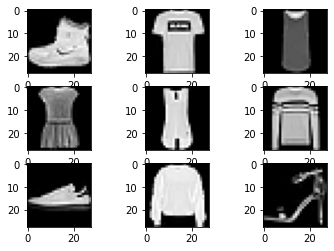

In [3]:
from matplotlib import pyplot
for i in range(9):  
    plt.subplot(330 + 1 + i)
    plt.imshow(train_X[i], cmap='gray')
plt.show()

<h3>Printing the shapes of train and test data</h3>

In [4]:
print("train_X shape" + str(train_X.shape))
print("train_y shape" + str(train_y.shape))
print("test_X shape" + str(test_X.shape))
print("test_y shape" + str(test_y.shape))

train_X shape(60000, 28, 28)
train_y shape(60000,)
test_X shape(10000, 28, 28)
test_y shape(10000,)


<h3>Function for converting numpy arrays to tensors, normalizing them, and reshaping them</h3>

In [5]:
def normalize(image):
    
    image = tf.cast(image, dtype=float)/255
    image = tf.reshape(image, [-1,])

    return image

<h3>Converting numpy arrays to datasets</h3>

In [6]:
train_X = tf.data.Dataset.from_tensor_slices(train_X)
train_y = tf.data.Dataset.from_tensor_slices(train_y)

test_X = tf.data.Dataset.from_tensor_slices(test_X)
test_y = tf.data.Dataset.from_tensor_slices(test_y)

<h3>Normalizing Train and Test Data</h3>

In [7]:
new_train_X = train_X.map(normalize)
new_test_X = test_X.map(normalize)

<h3>One-Hot Encoding</h3>

In [8]:
def one_hot_matrix(labels, depth = 10):
    
    one_hot = tf.reshape(tf.one_hot(labels, depth, axis = 0), [-1,])
    
    return one_hot


In [9]:
new_train_y = train_y.map(one_hot_matrix)
new_test_y = test_y.map(one_hot_matrix)

<h3>Initializing Parameters</h3>

In [10]:
def init_params(data_dims ,layer_dims):
    layer_dims.insert(0, data_dims)

    initializer = tf.keras.initializers.GlorotNormal()
    
    params = {}

    for l in range(1, len(layer_dims)):
        params["W" + str(l)] = tf.Variable(initializer(shape = (layer_dims[l], layer_dims[l-1])))
        params["b" + str(l)] = tf.Variable(initializer(shape = (layer_dims[l],1)))
        
    
    return params

<h3>Forward Propagation</h3>

In [11]:
def forward_propagation(X, params):
    n_layers = int(len(params)/2)

    Z = {}
    activations = {}

    for l in range(1, n_layers + 1):
        if l == 1:
            Z["Z" + str(l)] = tf.add(tf.matmul(params["W" + str(l)],X),params["b" + str(l)])
            activations["A" + str(l)] = tf.keras.activations.relu(Z["Z" + str(l)])
        elif l < n_layers:
            Z["Z" + str(l)] = tf.add(tf.matmul(params["W" + str(l)],activations["A" + str(l-1)]),params["b" + str(l)])
            activations["A" + str(l)] = tf.keras.activations.relu(Z["Z" + str(l)])
        else:
            Z["Z" + str(l)] = tf.add(tf.matmul(params["W" + str(l)],activations["A" + str(l-1)]),params["b" + str(l)])
            activations["A" + str(l)] = tf.keras.activations.softmax(Z["Z" + str(l)])

    return activations["A" + str(n_layers)]

<h3>Cost Function</h3>

In [12]:
def compute_cost(logits, labels):

    cost = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(y_pred=tf.transpose(logits),y_true=tf.transpose(labels),from_logits=True))

    return cost

<h3>Model</h3>

In [13]:
def model(train_X, train_y, test_X, test_y, learing_rate, num_epochs, minibatch_size, layer_dims):

    costs = []
    train_acc = []
    test_acc = []

    data_dims = 784

    parameters = init_params(data_dims, layer_dims)

    optimizer = tf.keras.optimizers.Adam(learing_rate)

    test_accuracy = tf.keras.metrics.CategoricalAccuracy()
    train_accuracy = tf.keras.metrics.CategoricalAccuracy()

    dataset = tf.data.Dataset.zip((train_X,train_y))
    test_dataset = tf.data.Dataset.zip((test_X,test_y))

    m = dataset.cardinality().numpy()

    minibatches = dataset.batch(minibatch_size).prefetch(8)
    test_minibatches = test_dataset.batch(minibatch_size).prefetch(8)
    

    for epoch in range(num_epochs):

        epoch_cost = 0

        train_accuracy.reset_states()

        for (minibatch_X, minibatch_y) in minibatches:

            with tf.GradientTape() as tape:
                AL = forward_propagation(tf.transpose(minibatch_X), parameters)

                minibatch_cost = compute_cost(AL, tf.transpose(minibatch_y))
            
            train_accuracy.update_state(minibatch_y, tf.transpose(AL))

            trainable_variables = [parameters[k] for k in parameters.keys()]
            grads = tape.gradient(minibatch_cost, trainable_variables)
            optimizer.apply_gradients(zip(grads, trainable_variables))
            epoch_cost += minibatch_cost
            
        epoch_cost /= m

        if epoch % 10 == 0:
            print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            print("Train accuracy:", train_accuracy.result())
        
            # We evaluate the test set every 10 epochs to avoid computational overhead
            for (minibatch_X, minibatch_Y) in test_minibatches:
                Z3 = forward_propagation(tf.transpose(minibatch_X), parameters)
                test_accuracy.update_state(minibatch_Y, tf.transpose(Z3))
            print("Test_accuracy:", test_accuracy.result())

            costs.append(epoch_cost)
            train_acc.append(train_accuracy.result())
            test_acc.append(test_accuracy.result())
            test_accuracy.reset_states()
    

    return parameters, costs, train_acc, test_acc         

    

    

In [15]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

with tf.device('/device:GPU:0'):
    parameters, costs, train_acc, test_acc = model(new_train_X, new_train_y, new_test_X, new_test_y, num_epochs=100, learing_rate= 0.001, minibatch_size= 32, layer_dims= [25,25,15,10])

Found GPU at: /device:GPU:0
Cost after epoch 0: 0.065218
Train accuracy: tf.Tensor(0.6885167, shape=(), dtype=float32)
Test_accuracy: tf.Tensor(0.7193, shape=(), dtype=float32)
Cost after epoch 10: 0.064383
Train accuracy: tf.Tensor(0.78065, shape=(), dtype=float32)
Test_accuracy: tf.Tensor(0.7757, shape=(), dtype=float32)
Cost after epoch 20: 0.064270
Train accuracy: tf.Tensor(0.7871, shape=(), dtype=float32)
Test_accuracy: tf.Tensor(0.7735, shape=(), dtype=float32)
Cost after epoch 30: 0.064245
Train accuracy: tf.Tensor(0.7861, shape=(), dtype=float32)
Test_accuracy: tf.Tensor(0.78, shape=(), dtype=float32)
Cost after epoch 40: 0.064232
Train accuracy: tf.Tensor(0.7837, shape=(), dtype=float32)
Test_accuracy: tf.Tensor(0.781, shape=(), dtype=float32)
Cost after epoch 50: 0.064204
Train accuracy: tf.Tensor(0.78105, shape=(), dtype=float32)
Test_accuracy: tf.Tensor(0.7707, shape=(), dtype=float32)
Cost after epoch 60: 0.064154
Train accuracy: tf.Tensor(0.77793336, shape=(), dtype=float

Text(0.5, 1.0, 'Learning Rate = 0.0001')

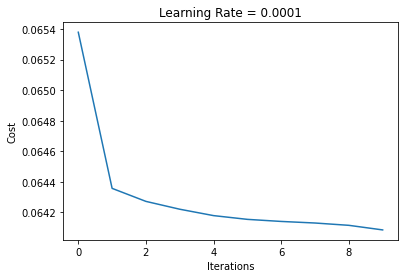

In [ ]:
import pickle

with open('Params~V1.0.pkl', 'wb') as f:
    pickle.dump(parameters, f)

plt.plot(numpy.squeeze(costs))
plt.ylabel("Cost")
plt.xlabel("Iterations")
plt.title("Learning Rate = 0.0001")